In [1]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as random

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDClassifier

from calibration_util import *
from kendall_errors import *
%matplotlib inline
%precision 3

/home/caitlin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'%.3f'

In [55]:
def formatRank(df):
    tmp = pd.DataFrame()
    tmp['y']=df.sort_values('y_pred',ascending=False).index
    tmp['y_pred']=tmp.index
    tmp['g']=df.sort_values('y_pred',ascending=False)['g']
    return tmp

In [56]:
def readFA_IRData(inpath, filename):
    
    return formatRank(pd.read_pickle(inpath+filename))

In [59]:
def getAllFA_IRData(inpath):
    d ={}

    d['cb'] = readFA_IRData(inpath, 'ColorblindRanking.pickle')
    d['feld'] = readFA_IRData(inpath, 'FeldmanRanking.pickle')
    d['fair1'] = readFA_IRData(inpath, 'FairRanking01PercentProtected.pickle')
    d['fair2'] = readFA_IRData(inpath, 'FairRanking02PercentProtected.pickle')
    d['fair3'] = readFA_IRData(inpath, 'FairRanking03PercentProtected.pickle')
    d['fair4'] = readFA_IRData(inpath, 'FairRanking04PercentProtected.pickle')
    d['fair5'] = readFA_IRData(inpath, 'FairRanking05PercentProtected.pickle')
    d['fair6'] = readFA_IRData(inpath, 'FairRanking06PercentProtected.pickle')
    d['fair7'] = readFA_IRData(inpath, 'FairRanking07PercentProtected.pickle')
    d['fair8'] = readFA_IRData(inpath, 'FairRanking08PercentProtected.pickle')
    d['fair9'] = readFA_IRData(inpath, 'FairRanking09PercentProtected.pickle')
    return d

In [74]:
german = getAllFA_IRData('data/processed/fa_ir_german_credit/GermanCreditAge25')
compas_gender = getAllFA_IRData('data/processed/fa_ir_compas_gender/CompasGender')
compas_race = getAllFA_IRData('data/processed/fa_ir_compas_race/CompasRace')

In [75]:
len(compas_race['cb'])

6889

In [76]:
def plot_all(data): 
    plt.figure(figsize=(12, 3,))
    plt.subplot(131) # equivalent to: plt.subplot(2, 2, 1)
    
    e0,e1 = sliding_kendall_parity(data, window=300, step=10)
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.ylim([0,1])
    plt.title("Parity")

    plt.subplot(132) # equivalent to: plt.subplot(2, 2, 1)
    e0,e1 = sliding_kendall_cal2(data, window=300, step=10)
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.ylim([0,1])
    plt.title("Calibration")

    plt.subplot(133) # equivalent to: plt.subplot(2, 2, 1)
    e0,e1 = sliding_kendall_eq(data, window=300, step=10)
    plt.ylim([0,1])
    plt.plot(e0, color='red')
    plt.plot(e1, color='blue')
    plt.title("Equality")
    plt.show()

    synth_errs = diagnose_k(data)
    print(synth_errs.transpose().round(2))

In [77]:
def get_all_errs(df, err, window=100, step=10):
    err0,err1 = err(df, window, step)
    errs=[]
    r0=stats.zscore(range(len(err0)))
    r1=stats.zscore(range(len(err1)))
    c0=stats.pearsonr(err0,r0)[0]
    
    c1=stats.pearsonr(err1,r1)[0]
#     print(c0,np.std(r0),np.std(err0))
    errs.append(c0 * (np.std(r0)/np.std(err0)))
    errs.append(c1 * (np.std(r1)/np.std(err1)))
    errs.append(stats.pearsonr(err0,err1)[0])
#     errs.append(np.linalg.norm(np.array(err0) - np.array(err1)))
    diffs = np.abs(np.array(err0) - np.array(err1))
    
    errs.append(np.sum(diffs) / len(err0))
    errs.append(stats.ttest_ind(err0,err1)[1])
    return errs

def norm(x):
    x = (x - np.mean(x))/np.std(x)
    

In [78]:
def diagnose_k(df):
     
#     dfs= run(data_g,data_y,data_X)
    
    errs=pd.DataFrame(index=[['trend0','trend1','cor','dist','sig']])
    #statistical parity
    errs['parity'] = get_all_errs(df, sliding_kendall_parity, window=100, step=10)
        
    #Calibration
    errs['cal'] = get_all_errs(df, sliding_kendall_cal2, window=100, step=10)
        
    #Equalized Odds
    errs['eq'] = get_all_errs(df, sliding_kendall_eq, window=100, step=10)
        
    return errs

German Credit: 
colorblind


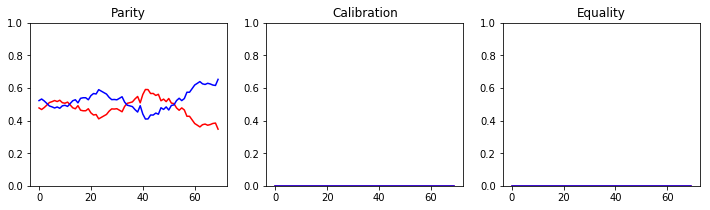

/home/caitlin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/caitlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/caitlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


        trend0  trend1  cor  dist   sig
parity    0.63   -0.63 -1.0  0.18  0.13
cal        NaN     NaN  NaN  0.00   NaN
eq         NaN     NaN  NaN  0.00   NaN
feldman


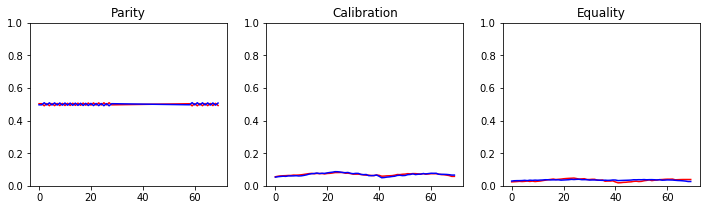

        trend0  trend1   cor  dist   sig
parity    1.03   -1.03 -1.00  0.03  0.13
cal     -10.23   -5.48  0.85  0.02  0.72
eq       -2.41  -23.40  0.34  0.02  0.47
fair 1


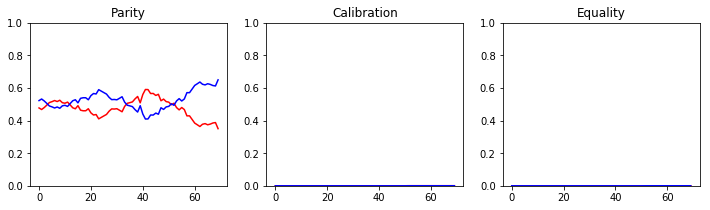

        trend0  trend1   cor  dist   sig
parity    0.48   -0.48 -1.00  0.16  0.06
cal     246.51  397.40  0.94  0.00  0.19
eq         NaN  381.29   NaN  0.00  0.00
fair 3


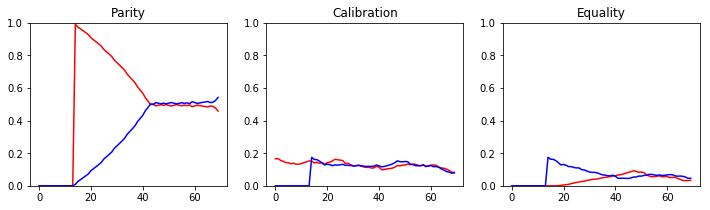

        trend0  trend1   cor  dist   sig
parity    2.47    3.70  0.74  0.07  0.21
cal     -11.98    8.65 -0.03  0.07  0.00
eq       11.70   13.50  0.40  0.03  0.11
fair 5


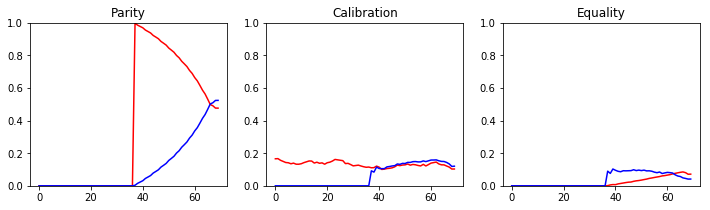

        trend0  trend1   cor  dist   sig
parity    2.45    3.71  0.70  0.07  0.12
cal     -13.41   10.24 -0.03  0.09  0.00
eq       18.08   19.88  0.70  0.01  0.73
fair 7


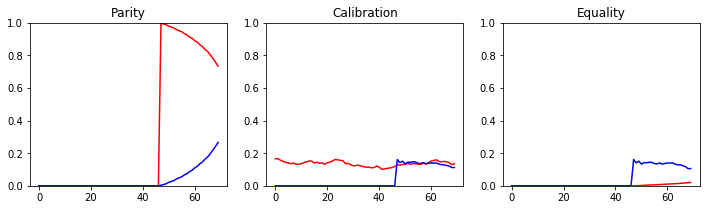

        trend0  trend1   cor  dist   sig
parity    2.26    3.80  0.62  0.08  0.05
cal     -11.13   12.61 -0.08  0.11  0.00
eq       45.61   10.85  0.37  0.02  0.02


In [79]:
print("German Credit: ")
print("colorblind")
plot_all(german['cb'])
print("feldman")
plot_all(german['feld'])
print("fair 1")
plot_all(german['fair1']) 
print("fair 3")
plot_all(german['fair3']) 
print("fair 5")
plot_all(german['fair5'])
print("fair 7")
plot_all(german['fair7'])

Compas Gender: 
colorblind


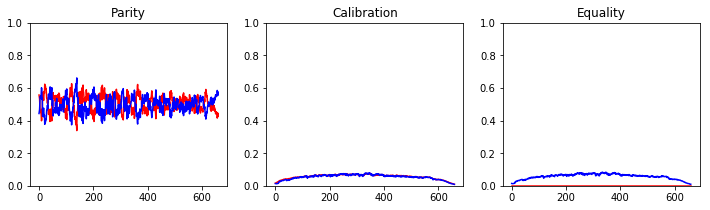

/home/caitlin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/caitlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


        trend0  trend1   cor  dist   sig
parity   -0.50    0.50 -1.00  0.15  0.38
cal      -3.81   -1.82  0.93  0.01  0.00
eq         NaN   -0.79   NaN  0.15  0.00
feldman


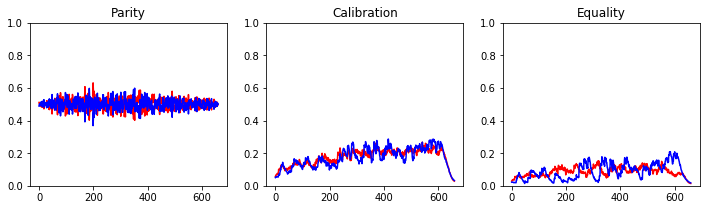

        trend0  trend1   cor  dist   sig
parity    0.12   -0.12 -1.00  0.14  0.80
cal       4.47    4.01  0.80  0.04  0.62
eq        1.02    4.11 -0.27  0.08  0.66
fair 1


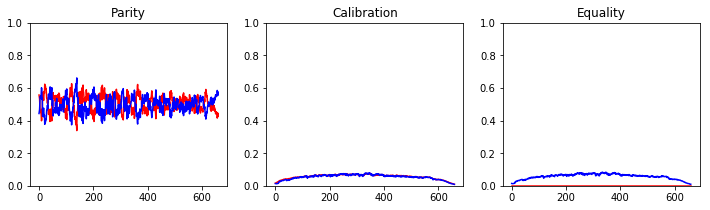

        trend0  trend1   cor  dist   sig
parity   -0.50    0.50 -1.00  0.15  0.38
cal      -3.81   -1.82  0.93  0.01  0.00
eq         NaN   -0.79   NaN  0.15  0.00
fair 3


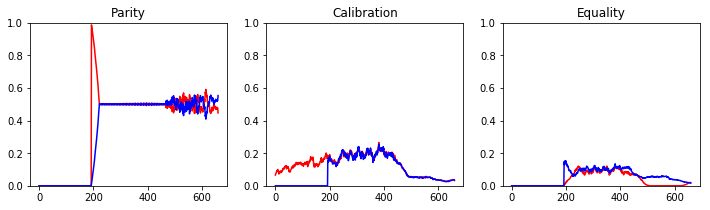

        trend0  trend1   cor  dist   sig
parity    3.20    3.44  0.91  0.04  0.64
cal      -3.33    3.70  0.58  0.07  0.00
eq        2.10    9.53  0.58  0.04  0.00
fair 5


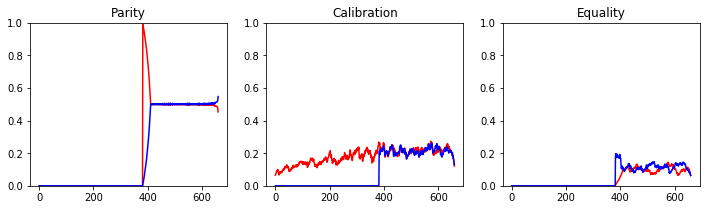

        trend0  trend1   cor  dist   sig
parity    3.28    3.49  0.95  0.01  0.58
cal       8.18    6.42  0.38  0.13  0.00
eq       12.65   11.51  0.88  0.02  0.06
fair 7


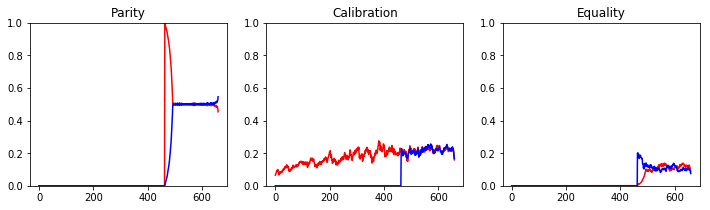

        trend0  trend1   cor  dist   sig
parity    3.20    3.50  0.93  0.01  0.46
cal       8.01    6.81  0.21  0.16  0.00
eq       13.18   12.93  0.93  0.01  0.90


In [80]:
print("Compas Gender: ")
print("colorblind")
plot_all(compas_gender['cb'])
print("feldman")
plot_all(compas_gender['feld'])
print("fair 1")
plot_all(compas_gender['fair1']) 
print("fair 3")
plot_all(compas_gender['fair3']) 
print("fair 5")
plot_all(compas_gender['fair5'])
print("fair 7")
plot_all(compas_gender['fair7'])

compas_race Credit: 
colorblind


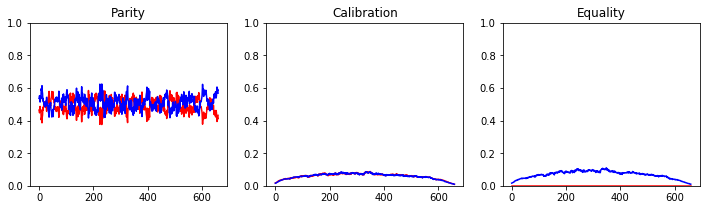

/home/caitlin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/caitlin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


        trend0  trend1   cor  dist   sig
parity   -0.35    0.35 -1.00  0.13  0.04
cal      -2.89   -3.92  0.96  0.01  0.96
eq         NaN   -2.19   NaN  0.18  0.00
feldman


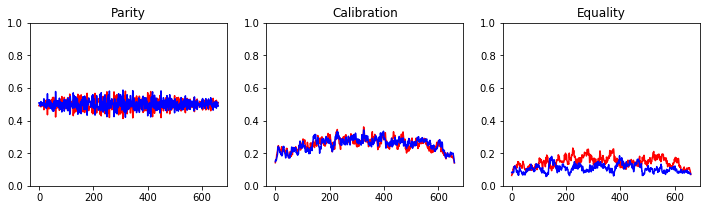

        trend0  trend1   cor  dist   sig
parity    0.05   -0.05 -1.00  0.13  0.91
cal      -1.06   -0.27  0.81  0.03  0.24
eq        0.08   -1.14 -0.41  0.08  0.00
fair 1


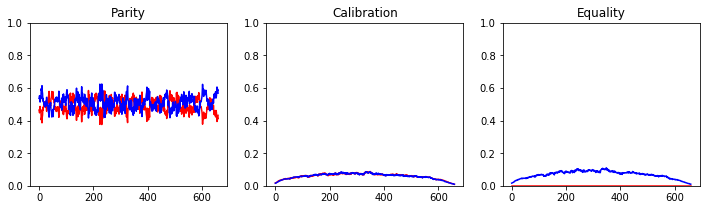

        trend0  trend1   cor  dist   sig
parity   -0.35    0.35 -1.00  0.13  0.04
cal      -2.89   -3.92  0.96  0.01  0.96
eq         NaN   -2.19   NaN  0.18  0.00
fair 3


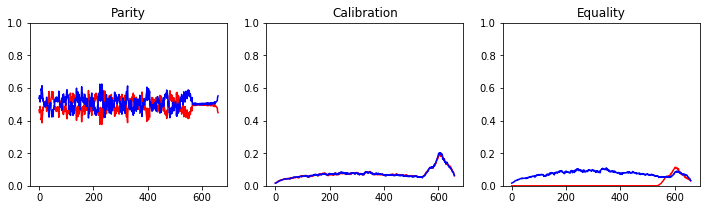

        trend0  trend1   cor  dist   sig
parity   -0.19    0.19 -1.00  0.12  0.06
cal       9.74    8.81  0.95  0.01  0.79
eq       13.58   -1.70 -0.48  0.17  0.00
fair 5


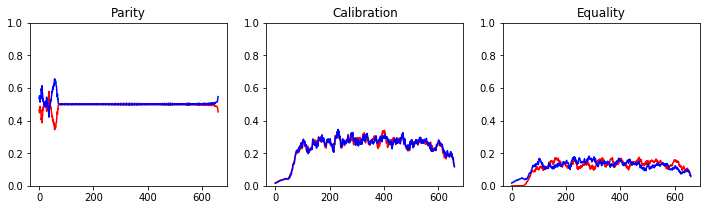

        trend0  trend1   cor  dist   sig
parity    2.23   -2.23 -1.00  0.03  0.01
cal       2.82    2.92  0.97  0.02  0.91
eq        6.57   -0.78  0.34  0.05  0.00
fair 7


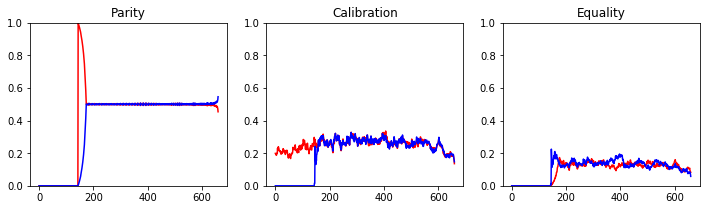

        trend0  trend1   cor  dist  sig
parity    3.12    3.50  0.91  0.02  0.4
cal      -0.42    4.16  0.59  0.07  0.0
eq        8.30    7.23  0.87  0.02  0.4


In [81]:
print("compas_race Credit: ")
print("colorblind")
plot_all(compas_race['cb'])
print("feldman")
plot_all(compas_race['feld'])
print("fair 1")
plot_all(compas_race['fair1']) 
print("fair 3")
plot_all(compas_race['fair3']) 
print("fair 5")
plot_all(compas_race['fair5'])
print("fair 7")
plot_all(compas_race['fair7'])